In [1]:
from textfile_data import txt_parser
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mplhep as hep
import boost_histogram as bh
from plot_classes import EmptyPlot
from matplotlib import transforms
import pandas as pd

In [17]:
data = txt_parser("tHbb_v31_v3.txt")
numeric_data = data.astype(float)
data0      = numeric_data[numeric_data[1] == 0]
data1      = numeric_data[(numeric_data[1] == 1) & (numeric_data.index != 'gamma_stat_SR_bin_9')]
data_gamma = numeric_data[numeric_data.index == 'gamma_stat_SR_bin_9']
data1.index.to_list()

['tH_NORM', 'ttb_NORM', 'ttc_NORM']

In [11]:
"""
FIGSIZE DEPENDENT ON DATA SIZE + MPLHEP + BH

CANNOT CREATE BH OBJECT WITH PULL PLOT DATA STRUCTURE

Currently using a bh with symmetric right and left errors
"""

# generate boost histgrams

def bh_generator(pd_data):

    nbins = len(pd_data)
    values = np.array(pd_data[1].to_list()).T
    w = np.array(pd_data[2].to_list()).T

    h = bh.Histogram(bh.axis.Regular(nbins, 1, nbins, metadata=pd_data.index.to_list()), storage=bh.storage.Weight())
    h[...] = np.stack([values, w], axis=-1)
    
    return h

bh0 = bh_generator(data0)
bh1 = bh_generator(data1)


# Below a failed attempt to create a non-symmetric bh object

# randoms = np.random.uniform(size=nbins)

# h2 = bh.Histogram(bh.axis.Regular(nbins, 1, nbins), storage=bh.storage.Weight())
# h2[...] = np.stack([values, randoms], axis=-1)

# pd.set_option("display.max_rows", None, "display.max_columns", None) -> view all rows in pandas dataframe

# fig, ax = plt.subplots(figsize=(6,3))
# hep.histplot([h1, h2], histtype='errorbar', ax=ax)


class PythPullPlot(EmptyPlot):

    
    def __init__(self, bh_obj, spacing=0.5, **kwargs):        

        super().__init__(**kwargs)
        self.fill(bh_obj)
        
        # user can either control size or the spacing but one choice excludes the other
        if 'size' in kwargs.keys():
            print('Figure size cannot be changed for this type of plot.') # need logger
        else:
            self.set_figsize(spacing) # spacing between variables for pull plot            

        self.create_canvas()
        self.make_grid()
        self.ax = self.make_subplot(0, 1, 0, 1)
        self.set_color() # set default colormap

            
    def set_figsize(self, spacing):
        
        # variable figure length based on number of data points
        l = self.nvariables*spacing
        self.figsize = (3,l)
        
        
    def fill(self, bh_obj):
        
        self.container1d.append(bh_obj)
        self.store_data()
    
    
    def store_data(self):
        
        self.values         = self.container1d[0].values() # numpy array
        self.pos_vals       = self.container1d[0].variances() # numpy array
        (self.data_labels,) = self.container1d[0].axes.metadata # metadata of bh is tuple so need to unpack
        self.nvariables     = len(self.values)
        
        # store the central value of the pull plot
        self.center = self.values[0]
    
    
    def pull_plot(self, obj):
        # self.config_rcParams({'lines.markersize': 1}) # why does this not work at run time???? (for user)
        
        # define base transformations and rotation transformations
        base = self.ax.transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        # make plot
        hep.histplot(obj, histtype='errorbar', ax=self.ax, transform=rot+base, markersize=3, color='k')
        
        # set x and y limits
        self.ax.set_xlim(-(3+max(self.pos_vals)), 3+max(self.pos_vals))
        self.ax.set_ylim(-1, self.nvariables+1)
        
        test = np.arange(self.nvariables)
        test2 = np.linspace(1, self.nvariables, self.nvariables)
        print(test)
        print(test2)
        print(self.nvariables)
        
        # put variable names on vertical axes
        self.ax.set_yticks(test2, labels=self.data_labels, size=5)
        
        # remove axis ticks for left and right axis of plot
        # self.ax.tick_params(which="both", bottom=True, left=False, top=True, right=False)

        
        self.ax.fill_between([-2, 2], -0.5, self.nvariables - 0.5, color="yellow")
        self.ax.fill_between([-1, 1], -0.5, self.nvariables - 0.5, color="limegreen")
        
        self.ax.hlines(0, -3, 3)
        self.ax.hlines(self.nvariables, -3, 3)
        
    def display(self, save_name="", **dpi_kw):
        
        self.pull_plot(self.container1d[0])
        # self.fig.set_tight_layout(True)
        
        if save_name:
            self.saveimage(save_name, **dpi_kw)
    
    
    def show_content(self):
        # print out data content of histogram and returns pandas dataframe
        pass

In [ ]:
"""
FIGSIZE DEPENDENT ON DATA SIZE + MATPLOTLIB + PANDAS
"""

class PythPullPlot(EmptyPlot):

    
    def __init__(self, pd_obj, spacing=0.5, **kwargs):        

        super().__init__(**kwargs)
        self.fill(pd_obj)
        
        # user can either control size or the spacing but one choice excludes the other
        if 'size' in kwargs.keys():
            print('Figure size cannot be changed for this type of plot.') # need logger
        else:
            self.set_figsize(spacing) # spacing between variables for pull plot            

        self.create_canvas()
        self.make_grid()
        self.ax = self.make_subplot(0, 1, 0, 1)
        self.set_color() # set default colormap

            
    def set_figsize(self, spacing):
        
        # variable figure length based on number of data points
        l = self.nvariables*spacing
        self.figsize = (3,l)
        
        
    def fill(self, pd_obj):
        
        self.container1d.append(pd_obj)
        self.store_data()
    
    
    def store_data(self):
        
        self.values      = self.container1d[0][1] # pandas series
        self.pos_err     = self.container1d[0][2] # pandas series
        self.neg_err     = self.container1d[0][3] # pandas series
        self.data_labels = self.container1d[0].index.to_list() # list
        self.nvariables  = len(self.values)
        
        # central value of the pull plot
        self.center = self.values[0]
    
    
    def pull_plot(self):
        # self.config_rcParams({'lines.markersize': 1}) # why does this not work at run time???? (for user)
        
        # define base transformations and rotation transformations
        base = self.ax.transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        # make plot
        hep.histplot(obj, histtype='errorbar', ax=self.ax, transform=rot+base, markersize=3, color='k')
        
        # set x and y limits
        self.ax.set_xlim(-(3+max(self.pos_vals)), 3+max(self.pos_vals))
        self.ax.set_ylim(-1, self.nvariables+1)
        
        test = np.arange(self.nvariables)
        test2 = np.linspace(1, self.nvariables, self.nvariables)
        print(test)
        print(test2)
        print(self.nvariables)
        
        # put variable names on vertical axes
        self.ax.set_yticks(test2, labels=self.data_labels, size=5)
        
        # remove axis ticks for left and right axis of plot
        # self.ax.tick_params(which="both", bottom=True, left=False, top=True, right=False)

        
        self.ax.fill_between([-2, 2], -0.5, self.nvariables - 0.5, color="yellow")
        self.ax.fill_between([-1, 1], -0.5, self.nvariables - 0.5, color="limegreen")
        
        self.ax.hlines(0, -3, 3)
        self.ax.hlines(self.nvariables, -3, 3)
        
    def display(self, save_name="", **dpi_kw):
        
        self.pull_plot(self.container1d[0])
        self.fig.set_tight_layout(True)
        
        if save_name:
            self.saveimage(save_name, **dpi_kw)
    
    
    def show_content(self):
        # print out data content of histogram and returns pandas dataframe
        pass

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  7

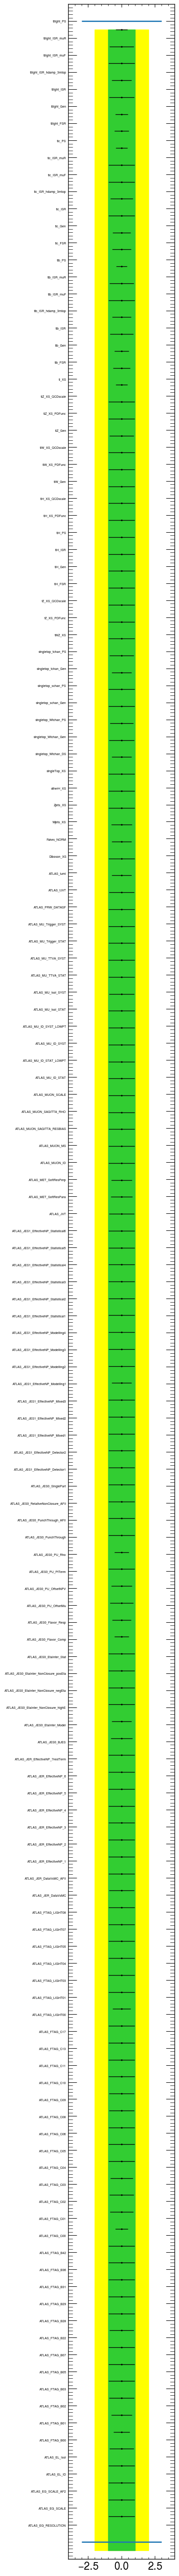

In [9]:
hist1 = PythPullPlot(bh0)
hist1.display()